# Import

In [2]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import random_split, DataLoader
import torchvision.models as models
import torch.nn.functional as F
from torchvision.models import resnet34


# Load the data

In [3]:
def load_batch(filename):
    with open(filename, 'rb') as f:
        data_dict = pickle.load(f, encoding='bytes')
        X = data_dict[b'data']
        Y = data_dict[b'labels']
        X = X.reshape(10000, 3, 32, 32).transpose(0, 2, 3, 1).astype("float")
        Y = np.array(Y)
        return X, Y
    
def load_training_data():
    X_train = []
    Y_train = []
    for i in range(1, 6):
        filename = f'./data_batch_{i}' 
        X, Y = load_batch(filename)
        X_train.append(X)
        Y_train.append(Y)
    X_train = np.concatenate(X_train)
    Y_train = np.concatenate(Y_train)
    return X_train, Y_train

def load_test_data():
    filename = './test_batch'
    X_test, Y_test = load_batch(filename)
    return X_test, Y_test


# Data preprocessing

In [4]:
# Data preprocessing
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load training and test datasets
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Split the training set into training and validation sets
train_size = int(0.8 * len(trainset))
val_size = len(trainset) - train_size
trainset, valset = random_split(trainset, [train_size, val_size])

# Creating a Data Loader
trainloader = DataLoader(trainset, batch_size=4, shuffle=True, num_workers=2)
valloader = DataLoader(valset, batch_size=4, shuffle=False, num_workers=2)
testloader = DataLoader(testset, batch_size=4, shuffle=False, num_workers=2)


Files already downloaded and verified
Files already downloaded and verified


# ResNet-34

Files already downloaded and verified
Files already downloaded and verified


D:\datascience\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
D:\datascience\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1: Train Loss=1.4243, Train Acc=50.56%, Val Loss=0.8531, Val Acc=71.07%
Epoch 2: Train Loss=0.8434, Train Acc=71.64%, Val Loss=0.6940, Val Acc=76.20%
Epoch 3: Train Loss=0.6978, Train Acc=76.73%, Val Loss=0.6383, Val Acc=77.70%
Epoch 4: Train Loss=0.6107, Train Acc=79.37%, Val Loss=0.5760, Val Acc=80.30%
Epoch 5: Train Loss=0.5440, Train Acc=81.49%, Val Loss=0.5468, Val Acc=81.55%
Epoch 6: Train Loss=0.4890, Train Acc=83.34%, Val Loss=0.5345, Val Acc=81.99%
Epoch 7: Train Loss=0.4450, Train Acc=84.97%, Val Loss=0.5012, Val Acc=83.19%
Epoch 8: Train Loss=0.4095, Train Acc=86.19%, Val Loss=0.4947, Val Acc=83.08%
Epoch 9: Train Loss=0.3816, Train Acc=86.91%, Val Loss=0.4901, Val Acc=83.40%
Epoch 10: Train Loss=0.3710, Train Acc=87.14%, Val Loss=0.4978, Val Acc=82.86%
Epoch 11: Train Loss=0.3615, Train Acc=87.72%, Val Loss=0.4912, Val Acc=83.21%
Epoch 12: Train Loss=0.3636, Train Acc=87.55%, Val Loss=0.4911, Val Acc=83.31%
Epoch 13: Train Loss=0.3593, Train Acc=87.82%, Val Loss=0.477

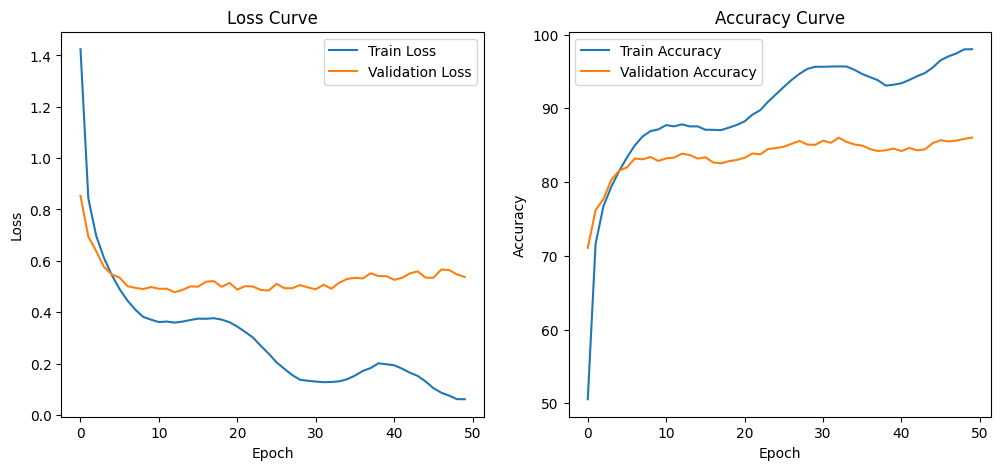

In [5]:
# Load the predefined ResNet-34 model and tune the output layer
class ResNet34Modified(nn.Module):
    def __init__(self):
        super(ResNet34Modified, self).__init__()
        self.model = resnet34(pretrained=True)
        self.model.fc = nn.Sequential(
            nn.Dropout(0.6),  
            nn.Linear(self.model.fc.in_features, 10)
        )

    def forward(self, x):
        return self.model(x)

# data enhancement
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

# Divide the training set and validation set
train_size = int(0.8 * len(trainset))
val_size = len(trainset) - train_size
trainset, valset = random_split(trainset, [train_size, val_size])

# data loader
trainloader = DataLoader(trainset, batch_size=100, shuffle=True)
valloader = DataLoader(valset, batch_size=100, shuffle=False)

# Models, Loss Functions and Optimizers
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ResNet34Modified().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)

# Training and validation with recording of losses and accuracies
train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []
for epoch in range(50):
    # train mode
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for images, labels in trainloader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    train_losses.append(running_loss / len(trainloader))
    train_accuracies.append(100 * correct / total)

    # Updated learning rate
    scheduler.step()

    # validation mode
    model.eval()
    val_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in valloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    val_losses.append(val_loss / len(valloader))
    val_accuracies.append(100 * correct / total)

    print(f'Epoch {epoch+1}: Train Loss={train_losses[-1]:.4f}, Train Acc={train_accuracies[-1]:.2f}%, '
          f'Val Loss={val_losses[-1]:.4f}, Val Acc={val_accuracies[-1]:.2f}%')

# Plotting loss and accuracy curves
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Curve')
plt.legend()

plt.show()


Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train Loss=1.6623, Train Acc=41.48%, Val Loss=1.0658, Val Acc=63.15%
Epoch 2: Train Loss=1.0667, Train Acc=63.60%, Val Loss=0.8975, Val Acc=69.11%
Epoch 3: Train Loss=0.9070, Train Acc=69.47%, Val Loss=0.7904, Val Acc=72.78%
Epoch 4: Train Loss=0.8082, Train Acc=73.13%, Val Loss=0.7459, Val Acc=74.46%
Epoch 5: Train Loss=0.7538, Train Acc=74.58%, Val Loss=0.7107, Val Acc=75.67%
Epoch 6: Train Loss=0.6985, Train Acc=76.42%, Val Loss=0.6798, Val Acc=76.58%
Epoch 7: Train Loss=0.6607, Train Acc=77.85%, Val Loss=0.6489, Val Acc=77.55%
Epoch 8: Train Loss=0.6273, Train Acc=78.62%, Val Loss=0.6382, Val Acc=77.99%
Epoch 9: Train Loss=0.6039, Train Acc=79.36%, Val Loss=0.6308, Val Acc=78.66%
Epoch 10: Train Loss=0.5901, Train Acc=79.78%, Val Loss=0.6245, Val Acc=78.59%
Epoch 11: Train Loss=0.5967, Train Acc=79.78%, Val Loss=0.6154, Val Acc=79.06%
Epoch 12: Train Loss=0.5896, Train Acc=79.82%, Val Loss=0.6223, 

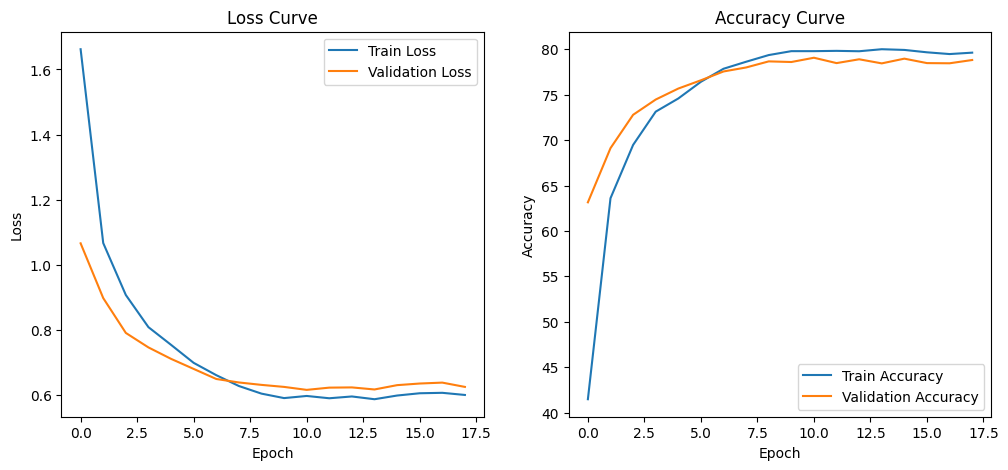

In [6]:
# Defining the ResNet-34 model and adjusting the output layer
class ResNet34Modified(nn.Module):
    def __init__(self):
        super(ResNet34Modified, self).__init__()
        self.model = resnet34(pretrained=True)
        self.model.fc = nn.Sequential(
            nn.Dropout(0.7), 
            nn.Linear(self.model.fc.in_features, 10)
        )

    def forward(self, x):
        return self.model(x)

# data enhancement
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),   
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1), 
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Models, Loss Functions and Optimizers
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ResNet34Modified().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)

# Parameters of the early stop mechanism
patience = 7 
best_val_loss = np.inf
early_stop_counter = 0

# Training and validation with recording of losses and accuracies
train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []
for epoch in range(50):
    # train mode
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for images, labels in trainloader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    train_losses.append(running_loss / len(trainloader))
    train_accuracies.append(100 * correct / total)

    # Updated learning rate
    scheduler.step()

    # validation mode
    model.eval()
    val_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in valloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    val_losses.append(val_loss / len(valloader))
    val_accuracies.append(100 * correct / total)

    print(f'Epoch {epoch+1}: Train Loss={train_losses[-1]:.4f}, Train Acc={train_accuracies[-1]:.2f}%, '
          f'Val Loss={val_losses[-1]:.4f}, Val Acc={val_accuracies[-1]:.2f}%')

    # Early Stop Mechanism
    if val_losses[-1] < best_val_loss:
        best_val_loss = val_losses[-1]
        early_stop_counter = 0 
    else:
        early_stop_counter += 1
        if early_stop_counter >= patience:
            print("stop")
            break

# Plotting loss and accuracy curves
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Curve')
plt.legend()

plt.show()
